# LELA 60342 Research Methods in Computational and Corpus Linguistics 2
# Week 7



# Generating with a recurrent neural network

The model structure that we used last week for classifying texts with an LSTM can also be used to generate text. We simply need to change the training data so that instead of predicting a label given a sequence of words as an input, the model is trained to predict the next word.

For our example here we will generate sequences of characters (as it keeps the "vocabulary" small). The training data will be all words that occur more than 3 times in Crime and Punishment

In [ ]:
!wget https://www.gutenberg.org/files/2554/2554-0.txt
# read in the file
import re
import pandas as pd
import torch
f = open('2554-0.txt')
c_and_p = f.read()
c_and_p=c_and_p.lower()
c_and_p=re.sub('\n',' ', c_and_p)
c_and_p=re.sub('[^a-z ]','', c_and_p)
c_and_p=re.sub(' +', ' ',c_and_p)
c_and_p=re.split(" ", c_and_p)
from collections import Counter
a=Counter(c_and_p)
words=[i for i,v in a.items() if v >= 4]


--2025-03-13 21:15:05--  https://www.gutenberg.org/files/2554/2554-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1159924 (1.1M) [text/plain]
Saving to: ‘2554-0.txt.1’

2554-0.txt.1        100%[===================>]   1.11M  4.84MB/s    in 0.2s    

2025-03-13 21:15:06 (4.84 MB/s) - ‘2554-0.txt.1’ saved [1159924/1159924]



In order to allow us to predict characters with a set length (of 5) we add a sequence of upper case characters to the beginning of the string (we lowercased the words so the characters won't occur inside the real words). \
In order to allow us to predict the ends of words, we add an end of word marker (the letter Z) to our sequences

In [ ]:
words=["ABCDE" + str.lower(x) + "Z" for x in words]
words

We then use hierachical indexing in Pandas to represent the data as sequences of separate characters nested inside words

In [ ]:
chars=[]
index_1=[]
index_2=[]
for i,w in enumerate(words):
    chars.extend(list(w))
    index_1.extend([i]*len(w))
    index_2.extend(range(len(w)))

words_as_chars = pd.DataFrame(chars,index=[index_1,index_2])
words_as_chars.columns = ["chars"]


In [ ]:
words_as_chars.head(10)

We can then use the Pandas function get_dummies to produce one-hot codings of the characters

In [ ]:
words_oh=pd.get_dummies(words_as_chars.chars,dtype=int)
words_oh

We then convert our dataframe in to 3d tensor of shape [number of words, length of longest word, size of "vocab"]. This requires us to pad the tensor for each word that is shorter than the longest word with additional tensors of zeros of length equal to the size of the "vocab".

In [ ]:
from torch import nn
# Find the length of the longest word in the data:
max_length=max([t[1] for t in words_as_chars.index])+1
# Make an array for the name tensors
X = [0] * (max([t[0] for t in words_as_chars.index])+1)
# Iterate over index of the surnames one-hot data frame. The indices are tuples.
for ind in words_oh.index:
    # Make a tensor from subset of the dataframe for this name/index
    s=torch.from_numpy(words_oh.loc[ind[0]].values).to(dtype=torch.float)
    # Pad the tensor
    m = nn.ZeroPad1d((0,0,max_length-len(s),0))
    # Add tensors to arrays
    X[ind[0]] = m(s)
# Combine contents of arrays into a single tensor
#print(X[2648])
X=torch.stack(X)

We then use this 3d tensor into an 2d output tensor y which contains the tensors for all the  character in all of our words in order, and a 3d input vector X which contains the tensor for each the N words that preceed each of the characters in y. N here is the length of the context that we want to use in our predictive model (we set this to be 5).  

In [ ]:
X_1=[]
y_1=[]
n_gram_length=5
for i in range(X.shape[0]):
    for j in range(n_gram_length,X[i].shape[0]):
          X_1.append(X[i,j-n_gram_length:j-1,:])
          y_1.append(X[i,j,:])
X=torch.stack(X_1)
y=torch.stack(y_1)


The model and training routine is then identical to that which we used for the classifiers last week. We just need to change the code to reflect the size of the input vector.

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
n_chars = 32

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_chars, hidden_size=15, num_layers=1, batch_first=True)
        self.linear = nn.Linear(15, n_chars)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [ ]:
from sklearn.utils import gen_batches
import matplotlib.pyplot as plt
n_epochs = 250
batch_size = 128
model = SeqModel()
#model.to("cuda")
ce_loss=[]
optimizer = optim.Adam(model.parameters(),lr=0.005)
loss_fn = nn.CrossEntropyLoss()

for i in range(n_epochs):
    cumul_loss = 0.0
    batches = gen_batches(X.shape[0],batch_size)
    cumul_loss=0.0
    for k in batches:
          inputs=X[k]
          outputs=y[k]
          y_pred = model(inputs)
          loss = loss_fn(y_pred, outputs)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          cumul_loss += loss.item()
    ce_loss.append(cumul_loss)

plt.plot(range(1,n_epochs),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

Once we have this trained model we can use it generate random text as follows:

In [ ]:
    input="ABCDE"
    oh = torch.zeros(7,len(charset))
    for i,c in enumerate(input):
        oh[i,charset.index(c)] = 1.0
    oh=torch.unsqueeze(oh,0)
    oh.shape

In [ ]:
import numpy as np
# Create a list of all the characters used in the words:
charset=list(words_oh.columns.values)
# Construct the prompt we want to use. In order to generate full words starting with the first letter, we provide an input equal to the
# upper case prefix we appended to our training data words. The first predicted character will then be a character that is likely to occur
# in first position
input="ABCDE"
# We are going to build up our words incrementally within a while loop and so we start by initializing empty strings for the next
# character in the sequence at each step, and for the full pseudo-word we are creating
pseudo_word=""
next_char=""
# We want to build up our word by incrementally adding characters until we reach an appropriate point to end. We therefore stop
# when the model predicts an end word character Z.
while next_char != "Z":
    # We create a tensor that represents the current state of the sequence. At beginning this is just the prompt. After that it is the last
    # five characters of the sequence created so far.
    oh = torch.zeros(7,len(charset))
    for i,c in enumerate(input):
        oh[i,charset.index(c)] = 1.0
    oh=torch.unsqueeze(oh,0)
    # We pass the tensor representation of the sequence so far into our model and pass the output through a softmax layer to generate
    # probabilities for each for each of the characters in our character set.
    #pred=model(torch.unsqueeze(oh,0))
    pred=model(oh)
    pred=nn.functional.softmax(pred,dim=1)
    pred=pred.detach().numpy().squeeze()
    # We now want to choose our next character. We can do this by randomly choosing a character, with the probability of each character being
    # sampled being equal to that output by the softmax. However we make a slight tweak and only sample from the 5 most likely characters.
    dict = {'chars': charset, 'probs': pred}
    s = pd.DataFrame(dict)
    s=s.sort_values(by="probs",ascending=False)[:5]
    next_char=np.random.choice(list(s.chars),1,list(s.probs))[0]

    # We add the sampled character to our pseudo word
    pseudo_word = pseudo_word + next_char
    # We create our next input to the model by adding the sampled character to the end of the sequence and remove the first character.
    input = input[1:] + next_char
print(pseudo_word)


# Encoder decoder network

A more practically useful application of a recurrent neural network for text generation is the Encoder-Decoder network.

We are going to implement a toy machine translation engine. It will take in English words and learn to output the same words in reverse.

In [2]:
!wget https://www.gutenberg.org/files/2554/2554-0.txt


--2025-03-14 10:07:54--  https://www.gutenberg.org/files/2554/2554-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1159924 (1.1M) [text/plain]
Saving to: ‘2554-0.txt.1’

2554-0.txt.1        100%[===================>]   1.11M   821KB/s    in 1.4s    

2025-03-14 10:07:57 (821 KB/s) - ‘2554-0.txt.1’ saved [1159924/1159924]



In [3]:
import re

In [268]:
import torch
from torch import nn
import pandas as pd
f = open('2554-0.txt')
c_and_p = f.read()
c_and_p=c_and_p.lower()
c_and_p=re.sub('\n',' ', c_and_p)
c_and_p=re.sub('[^a-z ]','', c_and_p)
c_and_p=re.sub(' +', ' ',c_and_p)
c_and_p=re.split(" ", c_and_p)
from collections import Counter
a=Counter(c_and_p)
words=[i for i,v in a.items() if v >=  1 and len(i) == 3]
chars=[]
chars_rev=[]
index_1=[]
index_2=[]
index_1_rev=[]
index_2_rev=[]
for i,w in enumerate(words):
    chars.extend(list(w))
    #chars.append("A")
    index_1.extend([i]*(len(w)))
    index_2.extend(range(len(w)))
    chars_rev.append("A")
    chars_rev.extend(list(w)[::-1])
    #chars_rev.extend(list(w))
    index_1_rev.extend([i]*(len(w)+1))
    index_2_rev.extend(range(len(w)+1))

words_as_chars = pd.DataFrame(chars,index=[index_1,index_2])
words_as_chars.columns = ["chars"]
words_as_chars_rev = pd.DataFrame(chars_rev,index=[index_1_rev,index_2_rev])
words_as_chars_rev.columns = ["chars"]
words_oh=pd.get_dummies(words_as_chars.chars,dtype=int)
words_oh_rev=pd.get_dummies(words_as_chars_rev.chars,dtype=int)

# Find the length of the longest word in the data:
max_length=max([t[1] for t in words_as_chars.index])+1
# Make an array for the name tensors
X = [0] * (max([t[0] for t in words_as_chars.index])+1)
# Iterate over index of the surnames one-hot data frame. The indices are tuples.
for ind in words_oh.index:
    # Make a tensor from subset of the dataframe for this name/index
    s=torch.from_numpy(words_oh.loc[ind[0]].values).to(dtype=torch.float)
    # Pad the tensor
    m = nn.ZeroPad1d((0,0,max_length-len(s),0))
    # Add tensors to arrays
    X[ind[0]] = m(s)
# Combine contents of arrays into a single tensor
X=torch.stack(X)
max_length_rev=max([t[1] for t in words_as_chars_rev.index])+1
# Make an array for the name tensors
X_rev = [0] * (max([t[0] for t in words_as_chars_rev.index])+1)
# Iterate over index of the surnames one-hot data frame. The indices are tuples.
for ind in words_oh_rev.index:
    # Make a tensor from subset of the dataframe for this name/index
    s=torch.from_numpy(words_oh_rev.loc[ind[0]].values).to(dtype=torch.float)
    # Pad the tensor
    m = nn.ZeroPad1d((0,0,max_length_rev-len(s),0))
    # Add tensors to arrays
    X_rev[ind[0]] = m(s)[1:]
# Combine contents of arrays into a single tensor
X_rev=torch.stack(X_rev)

In [274]:
X.shape

torch.Size([259, 3, 24])

In [354]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
n_chars_enc = 24

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        #self.linear = nn.Linear(n_chars_enc,n_chars_enc)
        self.gru = nn.GRU(input_size=n_chars_enc, hidden_size=16, num_layers=1, batch_first=True)
        #self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        #x=self.dropout(self.linear(x))
        x, h = self.gru(x)
        return h

In [355]:
import torch.nn.functional as F
n_chars_dec = 25

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        #self.linear1 = nn.Linear(n_chars_dec, n_chars_dec)
        self.gru = nn.GRU(input_size=n_chars_dec, hidden_size=16, num_layers=1, batch_first=True)
        self.linear2 = nn.Linear(16, n_chars_dec)
    def forward(self, x, hidden_state):
        #x=self.linear1(x)
        #x = F.relu(x)
        x, h  = self.gru(x, hidden_state)
        # take only the last output
        x = x[-1, :]
        x = self.linear2(x)
        return x, h

In [360]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = Encoder()
        self.Decoder = Decoder()

    def forward(self, x, teach):
        y = teach[0]
        tfr = teach[1]
        outputs= [0] * x.shape[0]
        for j,xi in enumerate(x):
           teacher_sig = y[j]
           h = self.Encoder(xi)
           xi = torch.zeros((1,n_chars_dec),device="cuda")
           xi[0,0] = 1.0
           output = [0] * 3
           for i in range(0,3):
             xi, h = self.Decoder(xi,h)
             xi=torch.unsqueeze(xi,0)
             # With a specified probability tfr the model will use the target token as the input from the previous step rather than the model output
             if np.random.binomial(1, tfr) == 1:
              xi = teacher_sig[i]
              xi=torch.unsqueeze(xi,0)
             output[i] = xi


           output=torch.stack(output)
           output=torch.squeeze(output,1)
           outputs[j]=output
        outputs=torch.stack(outputs)
        return outputs



0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'loss')

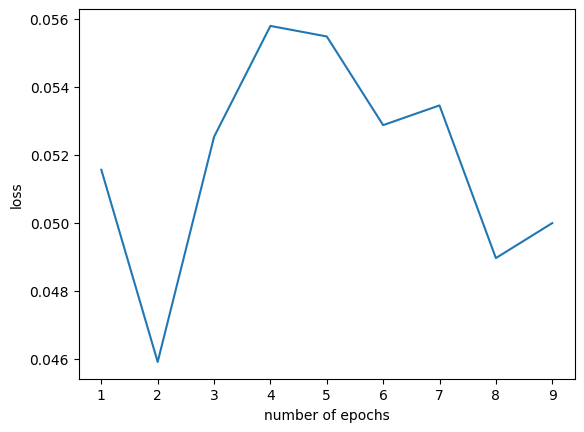

In [369]:
from sklearn.utils import gen_batches
import matplotlib.pyplot as plt
n_epochs =250
batch_size = 52
model = Seq2Seq()
tfr=0.2

ce_loss=[]
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model=model.to("cuda")
X=X.to("cuda")
X_rev=X_rev.to("cuda")

for i in range(n_epochs):
    print(i)
    batches = gen_batches(X.shape[0],batch_size)
    cumul_loss=0.0
    for batch in batches:
        inputs=X[batch]
        outputs=X_rev[batch]
        y_preds = model(inputs, (outputs, tfr))
        loss = loss_fn(y_preds, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumul_loss += loss.item()
    ce_loss.append(cumul_loss)
plt.plot(range(1,n_epochs),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

# Saving and loading models

Before we move on to building models I want to introduce something that will be very important as you build and train more complicated models - saving and loading models and models weights.

If you have a trained (or untrained or partially trained) model you can save it as follows:


In [320]:
torch.save(model, "word_reversal_model_0.pth")

The model can then be reloaded as follows:

In [368]:
model = torch.load("word_reversal_model_0.pth", weights_only=False)

If you have a model and you wanted to just save the weights (a more common situation as you will typically have the code for the model itself and simply want to save the trained weights) then you can do this as follows:

In [ ]:
torch.save(model.state_dict(), "word_reversal_model_0_weights.pth")

You can load the weights and add them to an instance of your model as follows:

In [363]:
model.load_state_dict(torch.load(PATH, weights_only=True))

FileNotFoundError: [Errno 2] No such file or directory: 'word_reversal_model_0_weights.pth'

To give this a try you can download a file with model and weights for the model above here:

In [370]:
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/word_reversal_model_0.pth

--2025-03-14 13:35:49--  https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/word_reversal_model_0.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22720 (22K) [application/octet-stream]
Saving to: ‘word_reversal_model_0.pth.1’

word_reversal_model 100%[===================>]  22.19K  --.-KB/s    in 0s      

2025-03-14 13:35:49 (160 MB/s) - ‘word_reversal_model_0.pth.1’ saved [22720/22720]



Loading third-party models


In [ ]:
from transformers import AutoModelForSeq2SeqLM
checkpoint = "google/mt5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Problem 1: The code below defines a function that takes in a word and applys the model above to it. It works occasionally. See it you can improve the model.

In [377]:
charset_enc=list(words_oh.columns)
charset_dec=list(words_oh_rev.columns)
def decode(input):
  test_word = torch.zeros((len(input),n_chars_enc),device="cuda")
  target_word = torch.zeros((len(input),n_chars_dec),device="cuda")
  for i in range(0,len(input)):
    test_word[i,charset_enc.index(input[i])] = 1.0
    target_word[i,charset_dec.index(input[i])] = 1.0
  output=torch.squeeze(model(torch.unsqueeze(test_word,0),(torch.unsqueeze(target_word,0),0)))
  decoded_word = ""
  for j in range(output.shape[0]):
    decoded_word += charset_dec[torch.argmax(output[j]).item()]
  return decoded_word

input="cat"
decode(input)

'tac'

Problem 2: Update the model above so that it will work with words of a different length.

# Code-breaking with an Encoder-Decoder network

Running the next cell will download and import a dataframe containing coded words paired with their uncoded forms. Train a network that learns to translate decode encoded words into their original form. Use this network to decode the next two encoded words:

ocpuk \
tudcr \

You will need to prepare the data

In [ ]:
!wget https://raw.githubusercontent.com/cbannard/lela60342/refs/heads/main/codes.csv
codes=pd.read_csv("codes.csv")